In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import os
import re
import scipy

import matplotlib 
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 22}
font2 = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 28}
matplotlib.rc('font', **font)
import matplotlib.font_manager as font_manager
from matplotlib import rcParams
matplotlib.rcParams['mathtext.fontset'] = 'cm'
from collections import OrderedDict
import matplotlib.ticker as ticker
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

In [2]:
import ROOT

Welcome to JupyROOT 6.26/02


## Try compton fits

- MACi-3 simulation of mono-energetic gamma-rays 0.2 - 2 MeV

```
cd build-LXe2/
sh runbash.sh
```

- Making root file with trees containing different calibration data

```
root -l scripts/getDataVaryE.C
```

- Results are written in `results/calibdata.root`


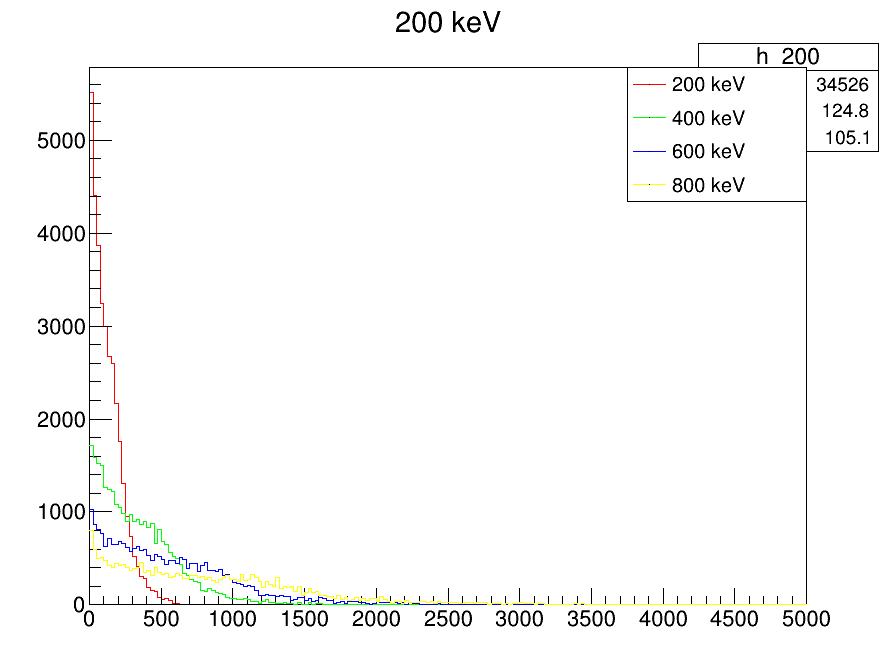

In [3]:
#Plotting
file0 = ROOT.TFile("results/calibdata.root")
trees = []
hists = []
nhists = 0
for i in range(200,800+200,200):
    trees.append(file0.Get("tree_%d" % i))
    hist = ROOT.TH1F("h_%d" % i ,"%d keV" %i,200,0,5000)
    hists.append(hist)
    nhists+=1
    
ncnt = 0
for idx,i in enumerate(trees):
    for jdx,j in enumerate(i):
        for k in range(4):
            if (i.e[k]>0):
#                 if (ncnt<5):
#                     print(i.e[k])
                hists[idx].Fill(i.e[k])
                ncnt+=1
c1 = ROOT.TCanvas("c1","c1",900,700)
c1.cd()

leg = ROOT.TLegend(0.7,0.7,0.9,0.9);
for idx,i in enumerate(hists):
    i.SetLineColor(2+idx)
    if (idx==0):
        i.Draw("hist")
    else:
        i.Draw("hist same")
    leg.AddEntry(i,i.GetTitle())
leg.Draw()
c1.Draw()
    

In [4]:
del c1
file0.Close()

In [5]:
#Using TKDE class
def getSimData(treename,hist):
    file0 = ROOT.TFile("results/calibdata.root")
    tree = file0.Get(treename)
    dat = []
    for jdx,tree in enumerate(tree):
        for k in range(4):
            if (tree.e[k]>0):
                dat.append(tree.e[k])
                hist.Fill(tree.e[k])
    hist.Scale(1./hist.Integral(),"width" )
    hist.SetStats(False)
#     file0.Close()
    return np.array(dat)


In [6]:
hist = ROOT.TH1F("_hist" ,"_hist", 200,0,1000)
dat = getSimData("tree_400",hist)
print(len(dat))

28429


### Using sklearn

(-1e-08, 1e-08)

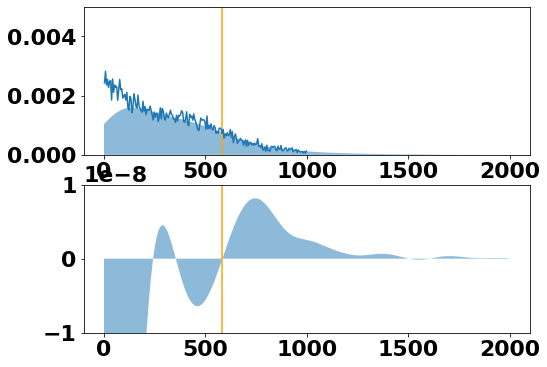

In [7]:
from sklearn.neighbors import KernelDensity
# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=100.0, kernel='gaussian')
kde.fit(np.array(dat)[:, None])
x_d = np.linspace(0, 2000, 200)
logprob = kde.score_samples(x_d[:, None])

fig,[ax1,ax2] = plt.subplots(2,1)
fig.set_size_inches(8,6)
ax1.fill_between(x_d, np.exp(logprob), alpha=0.5)

dydx = np.gradient(np.exp(logprob), x_d[1]-x_d[0])
d2ydx2 = np.gradient(dydx, x_d[1]-x_d[0])
ax2.fill_between(x_d, d2ydx2, alpha=0.5)
sign_beg  = 0
idx_compton = 0
flag_beg = False
thr = 0.1e-8
for idx,i in reversed(list(enumerate(d2ydx2))):
    if (abs(i)>thr):
        flag_beg = True
    if (flag_beg):
        if (sign_beg==0):
            if (i>0):
                sign_beg = 1
            else:
                sign_beg = -1
        if (i>0):
            sign = 1
        else:
            sign = -1
        if (sign!=sign_beg):
            idx_compton = idx
            break
ax2.axvline(x_d[idx_compton],color='orange')
ax1.axvline(x_d[idx_compton],color='orange')
        
xhist = []
yhist = []
for i in range(hist.GetNbinsX()):
    xhist.append(hist.GetBinCenter(i+1))
    yhist.append(hist.GetBinContent(i+1))
ax1.plot(xhist,yhist,'-')
ax1.set_ylim(0., 0.005)
ax2.set_ylim(-1.e-8, 1.e-8)

### Generalize the algorithm

In [8]:
def getSimData(treename,hbinparms=[200,0,-1]):
    file0 = ROOT.TFile("results/calibdata.root")
    tree = file0.Get(treename)
    dat = []
    for jdx,tree in enumerate(tree):
        for k in range(4):
            if (tree.e[k]>0):
                dat.append(tree.e[k])
    if (hbinparms[2]>0):
        hist = ROOT.TH1F(treename+"_hist" ,treename+"_hist", hbinparms[0],hbinparms[1],hbinparms[2])
    else:
        hist = ROOT.TH1F(treename+"_hist" ,treename+"_hist", hbinparms[0],hbinparms[1],max(dat))
    for jdx,tree in enumerate(tree):
        for k in range(4):
            if (tree.e[k]>0):
                hist.Fill(tree.e[k])
    
    hist.Scale(1./hist.Integral(),"width" )
    xhist = []
    yhist = []
    for i in range(hist.GetNbinsX()):
        xhist.append(hist.GetBinCenter(i+1))
        yhist.append(hist.GetBinContent(i+1))
    file0.Close()
    return np.array(dat),[xhist,yhist]

def getComptonEdgeSklearn(treename,threshold=1e-9,bandwidth= 100.,binsparms=[200,0,-1],hbinparms=[200,0,-1]):
    dat,histdata = getSimData(treename,hbinparms)
    kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
    kde.fit(np.array(dat)[:, None])
    if (binsparms[2]>0):
        x_d = np.linspace(binsparms[1], binsparms[2], binsparms[0])
    else:
        x_d = np.linspace(binsparms[1], max(dat), binsparms[0])
    logprob = kde.score_samples(x_d[:, None])
    dydx = np.gradient(np.exp(logprob), x_d[1]-x_d[0])
    d2ydx2 = np.gradient(dydx, x_d[1]-x_d[0])
    sign_beg  = 0
    idx_compton = 0
    flag_beg = False
    for idx,i in reversed(list(enumerate(d2ydx2))):
        if (abs(i)>threshold):
            flag_beg = True
        if (flag_beg):
            if (sign_beg==0):
                if (i>0):
                    sign_beg = 1
                else:
                    sign_beg = -1
            if (i>0):
                sign = 1
            else:
                sign = -1
            if (sign!=sign_beg):
                idx_compton = idx
                break
    return histdata,[x_d,np.exp(logprob),d2ydx2],x_d[idx_compton]

4234.321608040202


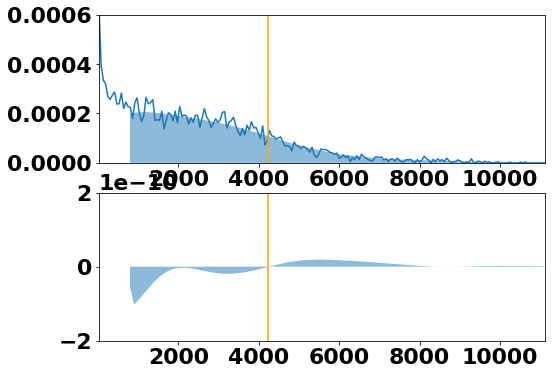

In [9]:
#Change threshold and bandwidth one by one
histdata,fitdata,e_compton = getComptonEdgeSklearn("tree_2000",threshold=1.e-11,bandwidth=800, binsparms=[200,800,-1])
fig,[ax1,ax2] = plt.subplots(2,1)
fig.set_size_inches(8,6)

ax1.fill_between(fitdata[0], fitdata[1], alpha=0.5)
ax1.plot(histdata[0],histdata[1],'-')
ax1.axvline(e_compton,color='orange')

ax2.fill_between(fitdata[0], fitdata[2], alpha=0.5)
ax2.axvline(e_compton,color='orange')


ax1.set_xlim(histdata[0][0], histdata[0][-1])
ax2.set_xlim(histdata[0][0], histdata[0][-1])

ax1.set_ylim(0., 0.0006)
ax2.set_ylim(-2.e-10, 2.e-10)
print(e_compton)

In [10]:
parms = [[200,0.5e-9,50],[400,0.5e-9,200],[600,0.5e-9,200],
         [800,0.5e-9,200],[1000,0.5e-9,200],[1200,1.e-10,500],
        [1400,1.e-10,500],[1600,1.5e-11,500],[1800,1.e-11,800],[1800,1.e-11,800]]

In [11]:
cnt = 0
x_prime = []
y_compton = []
for i in range(200,2200,200):
    histdata,fitdata,e_compton = getComptonEdgeSklearn("tree_%d" % i,threshold=parms[cnt][1],bandwidth=parms[cnt][2], binsparms=[200,parms[cnt][2],-1])
    cnt+=1
    x_prime.append(i)
    y_compton.append(e_compton)
    print(i,e_compton)

200 205.93969849246233
400 559.7386934673367
600 995.427135678392
800 1412.1708542713566
1000 1817.608040201005
1200 2354.2713567839196
1400 2818.065326633166
1600 3228.9447236180904
1800 3714.4221105527636
2000 4234.321608040202


(0.0, 5000.0)

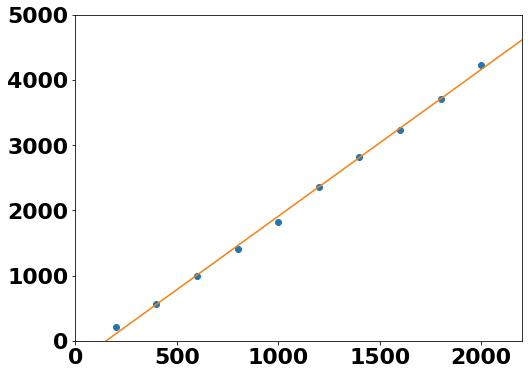

In [12]:
fig,ax = plt.subplots()
fig.set_size_inches(8,6)
xp = np.linspace(0, 2200, 500)
p = np.poly1d(np.polyfit(x_prime,y_compton,1))
ax.plot(x_prime,y_compton,'o',xp,p(xp),'-')
ax.set_xlim([0,2200])
ax.set_ylim([0,5000])

### => Good linear relationship

- However, banwidth and lower threshold still need to be given => Switch to Scipy tool that use bandwidth estimation method [https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html#scipy.stats.gaussian_kde](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html#scipy.stats.gaussian_kde)

### Using scipy

In [21]:
from scipy import stats
def getSimData(treename,nbins=200,ecutlow=0.,treefile="results/calibdata.root",):
    file0 = ROOT.TFile(treefile)
    tree = file0.Get(treename)
    dat = []
    for jdx,tree in enumerate(tree):
        for k in range(4):
            if (tree.e[k]>ecutlow):
                dat.append(tree.e[k])
    hist = ROOT.TH1F(treename+"_hist" ,treename+"_hist", nbins,0,max(dat))
    for jdx,tree in enumerate(tree):
        for k in range(4):
            if (tree.e[k]>ecutlow):
                hist.Fill(tree.e[k])
    
    hist.Scale(1./hist.Integral(),"width" )
    xhist = []
    yhist = []
    for i in range(hist.GetNbinsX()):
        xhist.append(hist.GetBinCenter(i+1))
        yhist.append(hist.GetBinContent(i+1))
    file0.Close()
    return np.array(dat),[xhist,yhist]

def getComptonEdgeScipy(treename,der_thr=1e-9,kdefactor = 0.5, ecutlow = 0.,nbins=200,treefile="results/calibdata.root"):
    dat,histdata = getSimData(treename,nbins,ecutlow,treefile)
    gkde_obj = stats.gaussian_kde(dat,kdefactor)
    x_d = np.linspace(0, max(dat), nbins)
    dydx = np.gradient(gkde_obj.evaluate(x_d), x_d[1]-x_d[0])
    d2ydx2 = np.gradient(dydx, x_d[1]-x_d[0])
    sign_beg  = 0
    idx_compton = 0
    flag_beg = False
    for idx,i in reversed(list(enumerate(d2ydx2))):
        if (abs(i)>der_thr):
            flag_beg = True
        if (flag_beg):
            if (sign_beg==0):
                if (i>0):
                    sign_beg = 1
                else:
                    sign_beg = -1
            if (i>0):
                sign = 1
            else:
                sign = -1
            if (sign!=sign_beg):
                idx_compton = idx
                break
    return histdata,[x_d,gkde_obj.evaluate(x_d),d2ydx2],x_d[idx_compton]

4260.201005025126


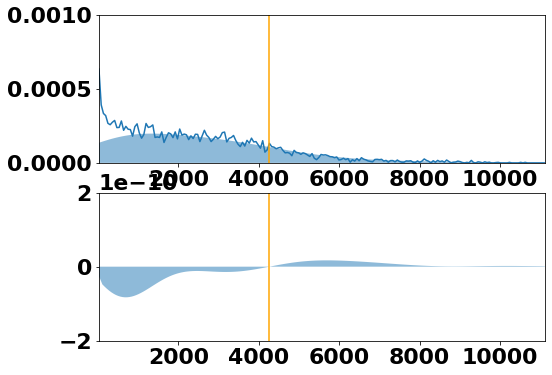

In [22]:
#Change threshold and kdefactor one by one
histdata,fitdata,e_compton = getComptonEdgeScipy("tree_2000",der_thr=1e-11,kdefactor=0.5)
fig,[ax1,ax2] = plt.subplots(2,1)
fig.set_size_inches(8,6)

ax1.fill_between(fitdata[0], fitdata[1], alpha=0.5)
ax1.plot(histdata[0],histdata[1],'-')
ax1.axvline(e_compton,color='orange')

ax2.fill_between(fitdata[0], fitdata[2], alpha=0.5)
ax2.axvline(e_compton,color='orange')


ax1.set_xlim(histdata[0][0], histdata[0][-1])
ax2.set_xlim(histdata[0][0], histdata[0][-1])

ax1.set_ylim(0., 0.001)
ax2.set_ylim(-2.e-10, 2.e-10)
print(e_compton)

In [15]:
parms = [[200,1.e-9,0.5],[400,1.e-9,0.5],[600,1.e-9,0.5],[800,1.e-10,0.5],
        [1000,1.e-10,0.5],[1200,1.e-10,0.5],[1400,1.e-11,0.5],[1600,1.e-11,0.5],
         [1800,1.e-11,0.5],[2000,1.e-11,0.5]]

In [16]:
cnt = 0
x_prime = []
y_compton = []
for i in range(200,2200,200):
    histdata,fitdata,e_compton = getComptonEdgeScipy("tree_%d" % i,parms[cnt][1],parms[cnt][2])
    cnt+=1
    x_prime.append(i)
    y_compton.append(e_compton)
    print(i,e_compton)

200 201.64824120603015
400 569.2160804020101
600 974.4422110552764
800 1423.7939698492464
1000 1923.7788944723618
1200 2339.1959798994976
1400 2820.402010050251
1600 3253.8693467336684
1800 3685.778894472362
2000 4260.201005025126


(0.0, 5000.0)

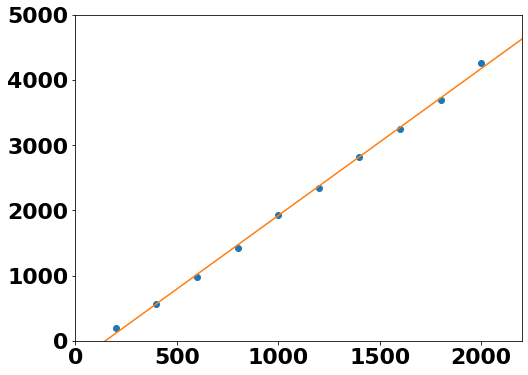

In [17]:
fig,ax = plt.subplots()
fig.set_size_inches(8,6)
xp = np.linspace(0, 2200, 500)
p = np.poly1d(np.polyfit(x_prime,y_compton,1))
ax.plot(x_prime,y_compton,'o',xp,p(xp),'-')
ax.set_xlim([0,2200])
ax.set_ylim([0,5000])

### => Scipy seem more robust!
### However, all have certain offset => Need at least two points to perform gain matching

### Compton edge for Co60

```
root -l
root [0] .L scripts/getDataVaryE.C
root [1] getSingle()
```

2564.211055276382


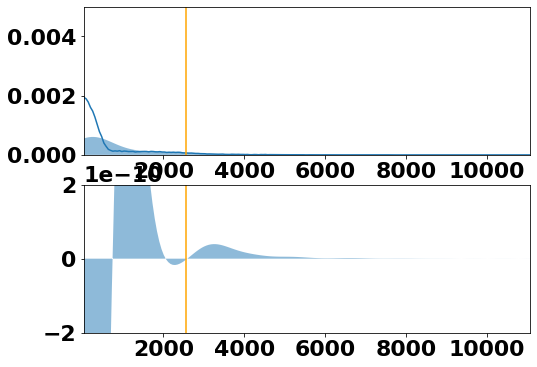

In [46]:
#Change threshold and kdefactor one by one
histdata,fitdata,e_compton = getComptonEdgeScipy("tree_Co60",der_thr=1e-11,kdefactor = 0.5, ecutlow = 0.,nbins=200,treefile="results/calibdataCo60.root")
fig,[ax1,ax2] = plt.subplots(2,1)
fig.set_size_inches(8,6)

ax1.fill_between(fitdata[0], fitdata[1], alpha=0.5)
ax1.plot(histdata[0],histdata[1],'-')
ax1.axvline(e_compton,color='orange')

ax2.fill_between(fitdata[0], fitdata[2], alpha=0.5)
ax2.axvline(e_compton,color='orange')


ax1.set_xlim(histdata[0][0], histdata[0][-1])
ax2.set_xlim(histdata[0][0], histdata[0][-1])

ax1.set_ylim(0., 0.005)
ax2.set_ylim(-2.e-10, 2.e-10)
print(e_compton)

(0.0, 5000.0)

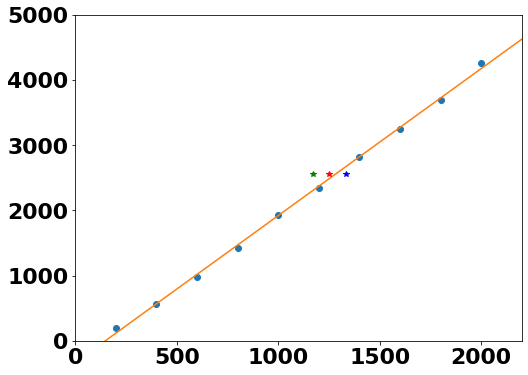

In [32]:
fig,ax = plt.subplots()
fig.set_size_inches(8,6)
xp = np.linspace(0, 2200, 500)
p = np.poly1d(np.polyfit(x_prime,y_compton,1))
ax.plot(x_prime,y_compton,'o',xp,p(xp),'-')
ax.plot([1332./2.+1173./2.],[e_compton],'*',color='r')
ax.plot([1173.],[e_compton],'*',color='g')
ax.plot([1332.],[e_compton],'*',color='b')
ax.set_xlim([0,2200])
ax.set_ylim([0,5000])

### => With Co60 source: good estimation assuming average enegy (1332./2.+1173./2.)

### => Test with real data

In [36]:
import json
 
def getComptonEdgeScipyFromJSON(jsonfile,branchname,der_thr=1e-9,kdefactor = 0.5, ecutlow = 0.,ecuthi = 1000000000.,nbins=200,treefile="results/calibdata.root"):
    # Opening JSON file
    with open(jsonfile) as f:
        dataall = json.load(f)
    dat = []
    for jdx,j in enumerate(dataall[branchname]):
        if (j>ecutlow and j<ecuthi):
            dat.append(j)
    dat = np.array(dat)
    hist = ROOT.TH1F(branchname ,branchname, nbins,0,max(dat))
    for jdx,j in enumerate(dataall[branchname]):
        if (j>ecutlow and j<ecuthi):
            hist.Fill(j)
    hist.Scale(1./hist.Integral(),"width" )
    xhist = []
    yhist = []
    for i in range(hist.GetNbinsX()):
        xhist.append(hist.GetBinCenter(i+1))
        yhist.append(hist.GetBinContent(i+1))
    histdata = [xhist,yhist]

    gkde_obj = stats.gaussian_kde(dat,kdefactor)
    x_d = np.linspace(0, max(dat), nbins)
    dydx = np.gradient(gkde_obj.evaluate(x_d), x_d[1]-x_d[0])
    d2ydx2 = np.gradient(dydx, x_d[1]-x_d[0])
    sign_beg  = 0
    idx_compton = 0
    flag_beg = False
    for idx,i in reversed(list(enumerate(d2ydx2))):
        if (abs(i)>der_thr):
            flag_beg = True
        if (flag_beg):
            if (sign_beg==0):
                if (i>0):
                    sign_beg = 1
                else:
                    sign_beg = -1
            if (i>0):
                sign = 1
            else:
                sign = -1
            if (sign!=sign_beg):
                idx_compton = idx
                break
    return histdata,[x_d,gkde_obj.evaluate(x_d),d2ydx2],x_d[idx_compton]

602.4120603015076


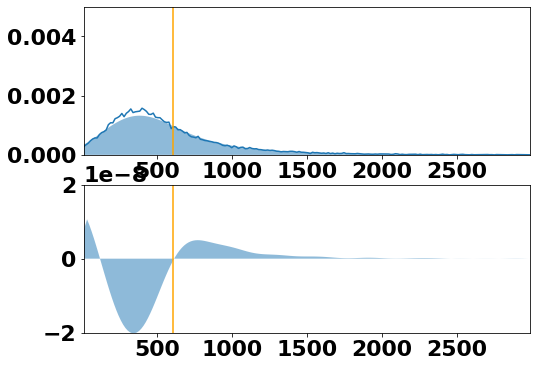

In [45]:
#Change threshold and kdefactor one by one
histdata,fitdata,e_compton = getComptonEdgeScipyFromJSON("results/Co60.json","ch0",der_thr=1e-10,kdefactor = 0.3, ecutlow = 0.,ecuthi = 3000.,nbins=200,treefile="results/calibdataCo60.root")
fig,[ax1,ax2] = plt.subplots(2,1)
fig.set_size_inches(8,6)

ax1.fill_between(fitdata[0], fitdata[1], alpha=0.5)
ax1.plot(histdata[0],histdata[1],'-')
ax1.axvline(e_compton,color='orange')

ax2.fill_between(fitdata[0], fitdata[2], alpha=0.5)
ax2.axvline(e_compton,color='orange')


ax1.set_xlim(histdata[0][0], histdata[0][-1])
ax2.set_xlim(histdata[0][0], histdata[0][-1])

ax1.set_ylim(0., 0.005)
ax2.set_ylim(-2.e-8, 2.e-8)
print(e_compton)